# Monte Carlo simulation of coupon bearing bonds using CIR

In [2]:
import pandas as pd, numpy as np
import edhec_risk_kit as erk
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
erk.discount([1,2,3,4,5], pd.Series([0.05, 0.03]))

,0,1
1,0.952381,0.970874
2,0.907029,0.942596
3,0.863838,0.915142
4,0.822702,0.888487
5,0.783526,0.862609


In [7]:
erk.bond_price(5, 100, 0.05, 12, 0.03)

0    109.275393
dtype: float64

In [8]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)

In [10]:
erk.bond_price(5, 100, 0.05, 12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

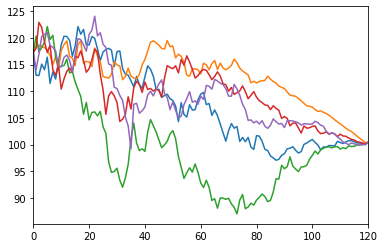

In [14]:
erk.bond_price(10, 100, 0.05, 12, rates[[1,2,3,4,5]]).plot(legend=False)

In [19]:
p = erk.bond_price(10, 100, 0.05, 12, rates[[1,2,3,4,5]])
btr = erk.bond_total_return(p, 100, 0.05, 12)
erk.annualized_ret(btr, 12)



1    0.031731
2    0.029330
3    0.035683
4    0.030652
5    0.031017
dtype: float64

In [20]:
price_10 = erk.bond_price(10, 100, 0.05, 12, rates)
price_10[[1,2,3]].tail()

,1,2,3
116,100.304,101.577,99.9473
117,100.282,101.167,99.8986
118,100.222,100.784,100.021
119,100.094,100.386,100.048
120,100.417,100.417,100.417


In [21]:
price_30 = erk.bond_price(30, 100, 0.05, 12, rates)
price_30[[1,2,3]].tail()

,1,2,3
116,112.712,193.648,97.9913
117,115.915,191.507,94.9701
118,119.05,192.046,101.625
119,115.721,189.861,107.627
120,116.628,191.911,106.562


In [27]:
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)
rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)
rets_bonds = 0.6*rets_10 + 0.4*rets_30

mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Max Drawdown
0,0.035332,0.003813,-0.248152,0.676007,-0.001034,0.000373,-0.000816


In [31]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [32]:
rets_eq = price_eq.pct_change().dropna()
rets_eq.shape

(120, 500)

In [35]:
rets = 0.7*rets_eq + 0.3*rets_bonds
rets_mean = rets.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Max Drawdown
0,0.059211,0.00467,-0.001795,0.066963,-0.002599,0.001793,0.0


# Naive risk budgeting strategies between PSP and GHP

In [42]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, 0.05, 12, rates)
price_30 = erk.bond_price(30, 100, 0.05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)
rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, erk.fixedmix_allocator, w1=0.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Max Drawdown
0,0.036295,0.003783,-0.187227,0.08011,-0.001132,0.000635,0.0


In [43]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [45]:
rets_7030b = erk.bt_mix(rets_eq, rets_zc, erk.fixedmix_allocator, w1=0.7)
mean_rets_7030b = rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(mean_rets_7030b))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Max Drawdown
0,0.058896,0.004584,0.324665,0.008677,-0.002738,0.002311,0.0


In [46]:
summaries = erk.summary_stats(rets_7030b)

In [47]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Max Drawdown
0,0.048686,0.101042,0.328056,0.658984,0.040237,-0.050498,-0.149724
1,0.044767,0.102204,0.315898,0.217455,0.041421,-0.051311,-0.214968
2,0.039995,0.106109,0.131916,0.199127,0.045161,-0.056651,-0.134185
3,0.077112,0.104744,-0.114111,-0.375855,0.044064,-0.055522,-0.143876
4,0.076225,0.100560,0.246131,-0.661364,0.039326,-0.043006,-0.167949


In [48]:
summaries.mean()

Annualized Return          0.053666
Annualized Vol             0.104939
Skewness                  -0.006902
Kurtosis                   0.032756
Cornish-Fisher VaR (5%)    0.044844
Historic CVaR             -0.056865
Max Drawdown              -0.204719
dtype: float64

In [53]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30")
], axis=1)

,FI,Eq,70/30
mean,1.389443,1.983411,1.766777
std,0.107645,0.940375,0.577605
p_breach,NaN,0.036000,0.010000
e_short,NaN,0.137200,0.085432
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [54]:
import seaborn as sns

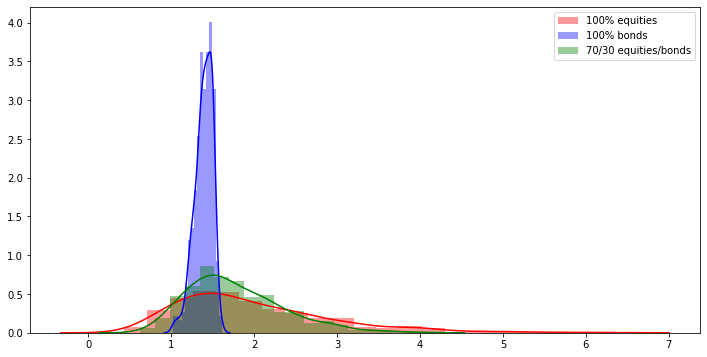

In [56]:
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="green", label="70/30 equities/bonds")
plt.legend()

In [63]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, erk.glidepath_allocator, start_glide=0.8, end_glide=0.2)
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30"),
    erk.terminal_stats(rets_g8020, name="Glide from 80 to 20")
], axis=1)

# Glidepath allocator typically does not solve the problem of breaching, although it reduces probability and e_short

,FI,Eq,70/30,Glide from 80 to 20
mean,1.389443,1.983411,1.766777,1.673237
std,0.107645,0.940375,0.577605,0.428646
p_breach,NaN,0.036000,0.010000,NaN
e_short,NaN,0.137200,0.085432,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


# Dynamic Risk Budgeting

In [64]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
prices_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [68]:
rets_eq = prices_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, erk.fixedmix_allocator, w1=0.7)
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
          erk.terminal_stats(rets_eq, name="EQ", floor=0.75),
          erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
          erk.terminal_stats(rets_floor75, name="floor75", floor=0.75)],
         axis=1).round(2)

,ZC,EQ,70/30,floor75
mean,1.34,2.03,1.79,2.00
std,0.00,1.02,0.61,1.03
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.13,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [71]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
          erk.terminal_stats(rets_eq, name="EQ", floor=0.75),
          erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
          erk.terminal_stats(rets_floor75, name="floor75", floor=0.75),
          erk.terminal_stats(rets_floor75m1, name="floor75m1", floor=0.75),
          erk.terminal_stats(rets_floor75m5, name="floor75m5", floor=0.75)],
         axis=1).round(2)

,ZC,EQ,70/30,floor75,floor75m1,floor75m5
mean,1.34,2.03,1.79,2.00,1.65,2.01
std,0.00,1.02,0.61,1.03,0.45,1.03
p_breach,NaN,0.03,0.01,NaN,NaN,NaN
e_short,NaN,0.13,0.07,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


# Risk budgeting with drawdown constraints

In [75]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, erk.drawdown_allocator, maxdd=0.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
          erk.terminal_stats(rets_eq, name="EQ", floor=0.75),
          erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
          erk.terminal_stats(rets_floor75, name="floor75", floor=0.75),
          erk.terminal_stats(rets_floor75m1, name="floor75m1", floor=0.75),
          erk.terminal_stats(rets_floor75m5, name="floor75m5", floor=0.75),
          erk.terminal_stats(rets_maxdd25, name="maxdd25", floor=0.75)],
         axis=1).round(2)

,ZC,EQ,70/30,floor75,floor75m1,floor75m5,maxdd25
mean,1.34,2.03,1.79,2.00,1.65,2.01,1.66
std,0.00,1.02,0.61,1.03,0.45,1.03,0.56
p_breach,NaN,0.03,0.01,NaN,NaN,NaN,NaN
e_short,NaN,0.13,0.07,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
max_dd = erk.summary_stats(rets_maxdd25)["Max Drawdown"]

In [78]:
max_dd.min()

-0.23465002446270158

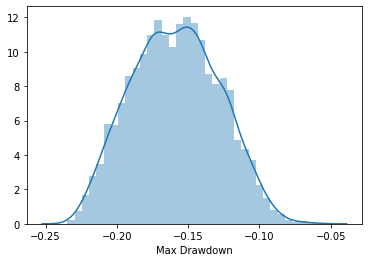

In [79]:
sns.distplot(max_dd)

(-0.6746167853414805, 6)

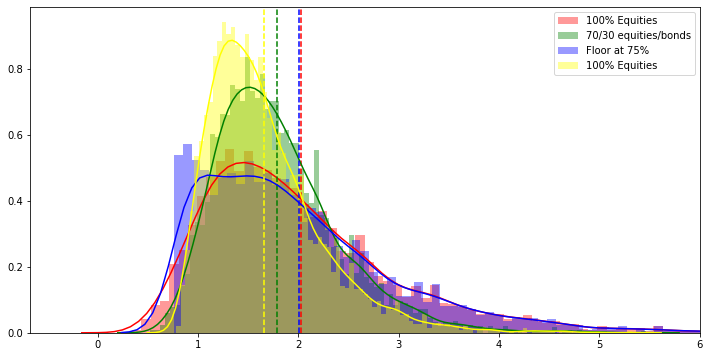

In [83]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
# Plot
plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="green", label="70/30 equities/bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="green")
sns.distplot(tv_floor75, color="blue", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="blue")
sns.distplot(tv_maxdd25, color="yellow", label="100% Equities", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend()
plt.xlim(right=6)

# Drawdown constraint with historic data

In [86]:
dd_tmi

,Wealth,Peaks,Drawdown
1990-01,0.927645,0.927645,0.000000
1990-02,0.943060,0.943060,0.000000
1990-03,0.966350,0.966350,0.000000
1990-04,0.940011,0.966350,-0.027256
1990-05,1.025124,1.025124,0.000000
...,...,...,...
2018-08,16.670740,16.670740,0.000000
2018-09,16.705880,16.705880,0.000000
2018-10,15.464771,16.705880,-0.074292
2018-11,15.758647,16.705880,-0.056701


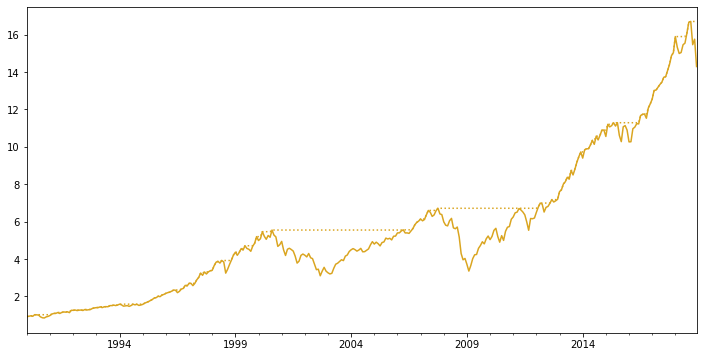

In [87]:
rets_tmi = erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12, 6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

In [96]:
dd_tmi["Wealth"]

1990-01     0.927645
1990-02     0.943060
1990-03     0.966350
1990-04     0.940011
1990-05     1.025124
             ...    
2018-08    16.670740
2018-09    16.705880
2018-10    15.464771
2018-11    15.758647
2018-12    14.294499
Freq: M, Name: Wealth, Length: 348, dtype: float64

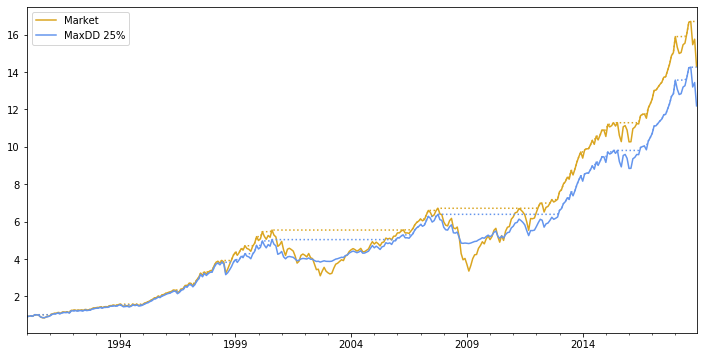

In [97]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0])
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, erk.drawdown_allocator, maxdd=0.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [99]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"),
                            rets_maxdd25[0].rename("MaxDD")],
                           axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Max Drawdown
Market,0.096058,0.145419,-0.671725,1.282831,0.06695,-0.094633,-0.499943
MaxDD,0.090062,0.112755,-0.633195,2.062034,0.04997,-0.071074,-0.244212


# Quiz

In [105]:
b1 = erk.bond_cash_flows(15, 1000, 0.05, 2)
b2 = erk.bond_cash_flows(5, 1000, 0.06, 4)
b3 = erk.bond_cash_flows(10, 1000, 0, 1)
ir = 0.05

In [204]:
b1_dur = erk.macaulay_duration(b1, ir/2)/2
b2_dur = erk.macaulay_duration(b2, ir/4)/4
b3_dur =  erk.macaulay_duration(b3, ir)
(b1_dur, b2_dur, b3_dur)

(10.72677495379012, 4.373363222636413, 10.0)

In [202]:
(erk.bond_price(15, 1000, 0.05, 2, ir),
 erk.bond_price(5, 1000, 0.06, 4, ir),
 erk.bond_price(10, 1000, 0, 1, ir))

(0    1000.0
 dtype: float64, 0    1043.99829
 dtype: float64, 0    613.913254
 dtype: float64)

In [185]:
erk.bond_price(15, 1000, 0.05, 2, ir/2)

0    1311.111328
dtype: float64

In [197]:
l_cf = pd.DataFrame(data=[100,200,300], index=[3,5,10])
l_df = erk.macaulay_duration(l_cf, ir)
l_df

6.750917852744651

In [194]:
b2_dur

(4.080205545924238,)

In [206]:
# Q8 
erk.match_durations2(l_df,
                     b2_dur,
                     b1_dur)

0.6257830075060314

In [207]:
erk.match_durations2(erk.macaulay_duration(l_cf, ir),
                     b2_dur,
                     b3_dur)

0.5774465770256697